/var/folders/fr/5_6br7tn5_j9cl4dbzgztk0c0000gn/T/ipykernel_6235/1125765674.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Step 1: Data Cleaning completed
Step 2: Feature Engineering completed
Step 3: Encoding completed

--- STEP 4: EDA ---


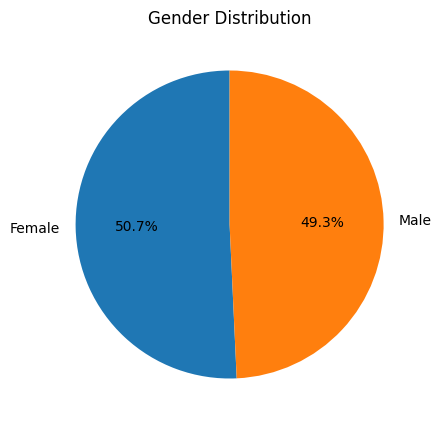

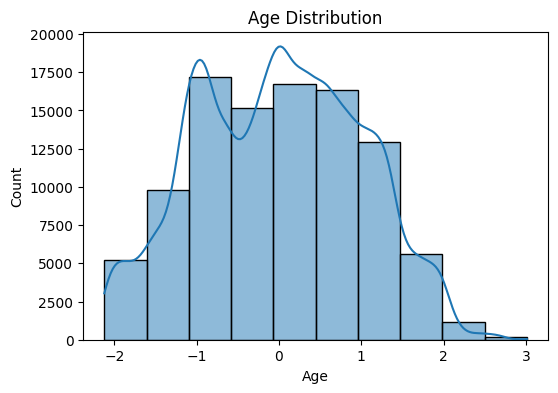

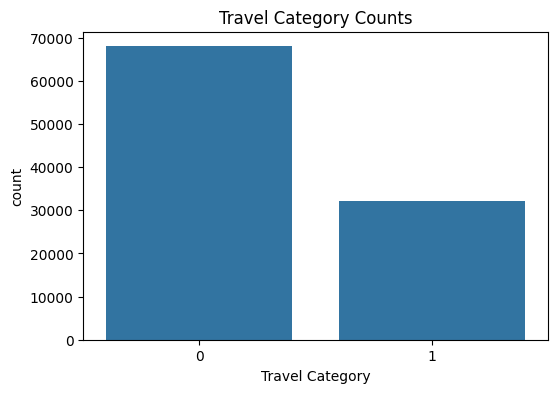


--- STEP 5: Descriptive Statistics Questions ---
Male: 49.27% | Female: 50.73%

Gender vs Satisfaction (%)
Satisfaction Encoded          0          1
Gender                                    
0                     58.534859  41.465141
1                     57.242063  42.757937

Average Age: -0.00
Age Range & Brackets:
count    1.002540e+05
mean    -2.317588e-16
std      1.000005e+00
min     -2.121250e+00
25%     -8.046115e-01
50%     -1.462823e-02
75%      7.753551e-01
max      3.013641e+00
Name: Age, dtype: float64
18-30    30238
31-45    31579
46-60    28991
61+       9446
Name: count, dtype: int64

Travel Category Counts:
Official           68040
Personal Travel    32214
Name: count, dtype: int64

Average Distance by Travel Category:
Travel Category
0    0.137532
1   -0.290485
Name: Distance Travelled, dtype: float64

Average Seat Comfort by Travel Class:
Travel Class
0    0.206504
1   -0.204812
2   -0.170805
Name: Seat Comfort, dtype: float64

Average Food Rating by Travel Class:

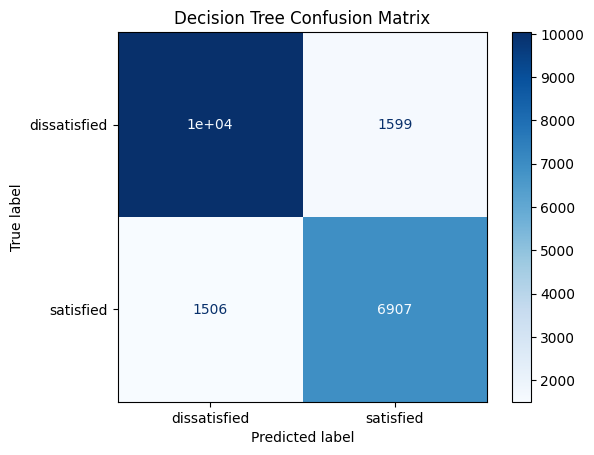


--- Random Forest ---
Accuracy: 0.9
Precision: 0.9
Recall: 0.86
F1-Score: 0.88


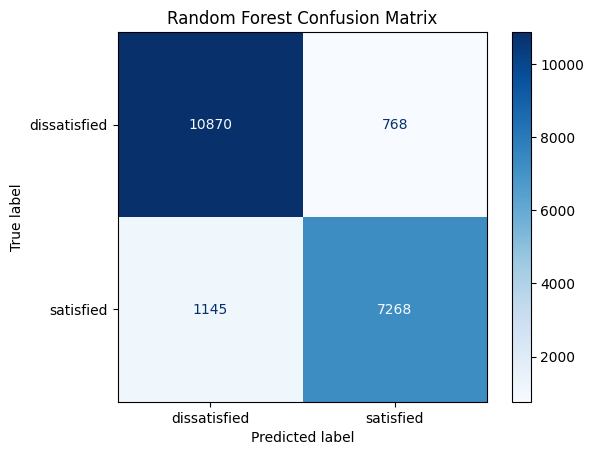


--- KNN ---
Accuracy: 0.69
Precision: 0.64
Recall: 0.61
F1-Score: 0.62


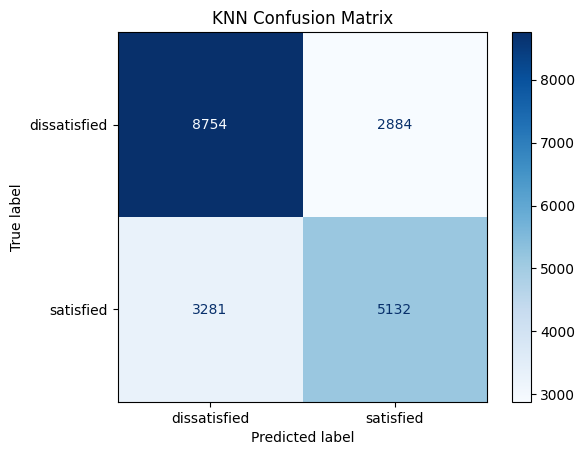


--- Logistic Regression ---
Accuracy: 0.82
Precision: 0.79
Recall: 0.78
F1-Score: 0.79


/Users/ramjeetdixit/MyEnv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


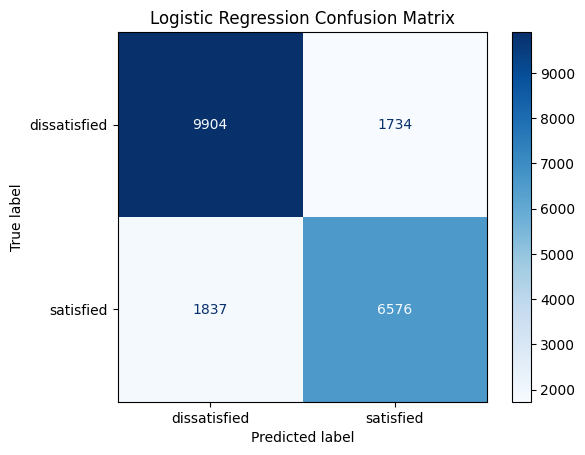


--- STEP 7: Conclusion ---
- Random Forest performs better due to ensemble averaging.
- Age, gender, travel class, and delays significantly impact satisfaction.
- Feature engineering, binning, normalization, and full encoding improved model performance.
Cleaned dataset saved successfully


In [37]:
# ======================================
# Customer Satisfaction Analysis & Modeling
# ======================================

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# ======================================
# STEP 1: Data Cleaning
# ======================================

df = pd.read_csv('/Users/ramjeetdixit/Desktop/Customer Satisfaction.csv')
df.columns = df.columns.str.strip()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Columns
numeric_cols = ['Age', 'Distance Travelled', 'Departure/Arrival Rating', 'Booking Ease',
                'Food', 'Seat Comfort', 'Entertainment', 'Leg Room', 'Luggage Handling',
                'Cleanliness', 'Departure Delay (min)', 'Arrival Delay (min)']
categorical_cols = ['Gender', 'Travel Category', 'Travel Class', 'Boarding Point']

# Handle Missing Values
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

df['Age'] = df['Age'].astype(int)
df['Satisfaction'] = df['Satisfaction'].astype('category')

# Outlier handling (<5%)
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    if len(outliers)/len(df) < 0.05:
        df = df[~((df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR))]

print("Step 1: Data Cleaning completed")

# ======================================
# STEP 2: Feature Engineering
# ======================================

# Total Delay
df['Total Delay'] = df['Departure Delay (min)'] + df['Arrival Delay (min)']

# Age Brackets
bins = [0, 30, 45, 60, 100]
labels = ['18-30','31-45','46-60','61+']
df['Age Bracket'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Distance Bin
distance_bins = [0, 500, 1000, 1500, 2000, df['Distance Travelled'].max()]
distance_labels = ['0-500','501-1000','1001-1500','1501-2000','2000+']
df['Distance Bin'] = pd.cut(df['Distance Travelled'], bins=distance_bins, labels=distance_labels, right=False)

# Average Rating
rating_cols = ['Departure/Arrival Rating', 'Booking Ease', 'Food', 'Seat Comfort',
               'Entertainment', 'Leg Room', 'Luggage Handling', 'Cleanliness']
df['Avg Rating'] = df[rating_cols].mean(axis=1)

# Normalize numeric columns
num_cols = numeric_cols + ['Total Delay', 'Avg Rating']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("Step 2: Feature Engineering completed")

# ======================================
# STEP 3: Encode All Categorical Features
# ======================================

all_categorical = ['Gender', 'Travel Category', 'Travel Class', 'Boarding Point', 'Age Bracket', 'Distance Bin']
le_dict = {}
for col in all_categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Encode target
le_target = LabelEncoder()
df['Satisfaction Encoded'] = le_target.fit_transform(df['Satisfaction'])

print("Step 3: Encoding completed")

# ======================================
# STEP 4: Exploratory Data Analysis (EDA)
# ======================================

print("\n--- STEP 4: EDA ---")

# Gender Distribution
plt.figure(figsize=(5,5))
plt.pie(df['Gender'].value_counts(), labels=le_dict['Gender'].inverse_transform(df['Gender'].value_counts().index),
        autopct='%1.1f%%', startangle=90)
plt.title("Gender Distribution")
plt.show()

# Age Distribution
plt.figure(figsize=(6,4))
sns.histplot(df['Age'], bins=10, kde=True)
plt.title("Age Distribution")
plt.show()

# Travel Category Counts
plt.figure(figsize=(6,4))
sns.countplot(x='Travel Category', data=df)
plt.title("Travel Category Counts")
plt.show()

# ======================================
# STEP 5: Descriptive Statistics Questions
# ======================================

print("\n--- STEP 5: Descriptive Statistics Questions ---")

# Gender Distribution & Satisfaction
gender_counts = df['Gender'].value_counts()
male_pct = gender_counts[le_dict['Gender'].transform(['Male'])[0]]/gender_counts.sum()*100
female_pct = gender_counts[le_dict['Gender'].transform(['Female'])[0]]/gender_counts.sum()*100
print(f"Male: {male_pct:.2f}% | Female: {female_pct:.2f}%")

gender_satisfaction = pd.crosstab(df['Gender'], df['Satisfaction Encoded'], normalize='index')*100
print("\nGender vs Satisfaction (%)")
print(gender_satisfaction)

# Age Analysis
print(f"\nAverage Age: {df['Age'].mean():.2f}")
print("Age Range & Brackets:")
print(df['Age'].describe())
age_brackets_count = pd.Series(le_dict['Age Bracket'].inverse_transform(df['Age Bracket']))
print(age_brackets_count.value_counts().sort_index())

# Travel Category
print("\nTravel Category Counts:")
print(pd.Series(le_dict['Travel Category'].inverse_transform(df['Travel Category'])).value_counts())

print("\nAverage Distance by Travel Category:")
print(df.groupby('Travel Category')['Distance Travelled'].mean())

# Travel Class Ratings
print("\nAverage Seat Comfort by Travel Class:")
print(df.groupby('Travel Class')['Seat Comfort'].mean())
print("\nAverage Food Rating by Travel Class:")
print(df.groupby('Travel Class')['Food'].mean())

# Delay Analysis
print("\nAverage Departure and Arrival Delay:")
print(df[['Departure Delay (min)','Arrival Delay (min)']].mean())

print("\nImpact of Delays on Satisfaction:")
print(df.groupby('Satisfaction Encoded')[['Departure Delay (min)','Arrival Delay (min)']].mean())

# ======================================
# STEP 6: Model Training and Evaluation
# ======================================

print("\n--- STEP 6: Model Training & Evaluation ---")

X = df.drop(['Satisfaction', 'Satisfaction Encoded'], axis=1)
y = df['Satisfaction Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=500)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n--- {name} ---")
    print("Accuracy:", round(accuracy_score(y_test, y_pred),2))
    print("Precision:", round(precision_score(y_test, y_pred, pos_label=1),2))
    print("Recall:", round(recall_score(y_test, y_pred, pos_label=1),2))
    print("F1-Score:", round(f1_score(y_test, y_pred, pos_label=1),2))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=le_target.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# ======================================
# STEP 7: Conclusion & Saving
# ======================================

print("\n--- STEP 7: Conclusion ---")
print("- Random Forest performs better due to ensemble averaging.")
print("- Age, gender, travel class, and delays significantly impact satisfaction.")
print("- Feature engineering, binning, normalization, and full encoding improved model performance.")

df.to_csv('/Users/ramjeetdixit/Desktop/Customer_Satisfaction_Cleaned_Full.csv', index=False)
print("Cleaned dataset saved successfully")